## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
# Get the device
if (torch.cuda.is_available()):
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

# # intialize a dataset
city = 'palo-alto' 
split = 'train'

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
#         tensor = torch.Tensor(self.feature[item])
#         tensorlabel = torch.Tensor(self.label[item])
#         return tensor.to(device), tensorlabel.to(device)

        data = np.concatenate((self.inputs[idx], self.outputs[idx]))
            
        if self.transform:
            data = self.transform(data)

        return torch.Tensor(data).to(device)
    

# process data
inputs, outputs = get_city_trajectories(city=city, split=split, normalized=False)
all_in_1 = []
for i in range(len(inputs)):
    togetherData = np.concatenate((inputs[i], outputs[i]))
    all_in_1.append(togetherData)


training_set_x = []
training_set_y = []
# every sentence has length 40, with the 41st character as target value
# set range step higher if overfit
for i, elem in enumerate(all_in_1):
    for j in range(0, 60):
        training_set_x.append(elem[j:j+50])
        training_set_y.append(elem[j+50])
    
    #   x: sentence (substring [:k], k is EXCLUSIVE)
#         training_set_x.append(all_in_1[i:i+40])
#     #   y: target value
#         training_set_y.append(all_in_1[i+40])
    
    
class mydataset(Dataset):
    def __init__(self, x, y):
        
        self.feature = x
        self.label = y
        
    def __getitem__(self, item):
        
        tensor = torch.Tensor(self.feature[item])
        tensorlabel = torch.Tensor(self.label[item])
        return tensor.to(device), tensorlabel.to(device)
    
    def __len__(self):
        return len(self.feature)

train_dataset = mydataset(training_set_x, training_set_y)
    

# train_dataset  = ArgoverseDataset(city = city, split = split)

In [3]:
inputs, outputs = get_city_trajectories(city=city, split='val', normalized=False)
val_in_1 = []
for i in range(len(inputs)):
    togetherData = np.concatenate((inputs[i], outputs[i]))
    val_in_1.append(togetherData)


val_set_x = []
val_set_y = []
# every sentence has length 40, with the 41st character as target value
# set range step higher if overfit
for i, elem in enumerate(val_in_1):
    for j in range(0, 60):
        val_set_x.append(elem[j:j+50])
        val_set_y.append(elem[j+50])
val_dataset = mydataset(val_set_x, val_set_y)        

In [4]:
# val_dataset = ArgoverseDataset(city = city, split = 'val')

In [20]:
# len(val_dataset)
# print(len(val_dataset))
print (len(all_in_1))

2399


## Create a DataLoader class for training

In [6]:
batch_sz = 64  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle = True)
test_loader = DataLoader(val_dataset, batch_size=batch_sz, shuffle = True)

In [7]:
from torch import nn, optim

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        #Hidden dimensions
        self.hidden_dim = hidden_dim
        
        #Number of hidden layers
        self.layer_dim = layer_dim
        
        #imput dim
        self.input_dim = input_dim
        
        
        #Building your LSTM
        #batch_first=True causes input/output tensors to be of shape
        #(batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        #Readout layer
        self.fc = nn.Linear (hidden_dim, output_dim)
        
#         self.Softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        #Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
#         print("h0 dtype: ", h0.dtype)
        
        #Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        
        #Output channel
#         output, (hn, cn) = self.lstm(x, (h0, c0))
        output, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        hn = hn.view(-1,self.hidden_dim)
        out = self.fc(hn)
        
#         out = output.view(-1,self.hidden_dim)
#         out = self.fc(out)

#         output, state = self.lstm(x, prev_state)
#         output = output.type(torch.LongTensor)
#         output = output.to(device)
#         out = self.Softmax(out)
        
        return out
    
#     def init_state(self, sequence_length):
#         return (torch.zeros(self.layer_dim, sequence_length, self.input_dim),
#                 torch.zeros(self.layer_dim, sequence_length, self.input_dim))

In [8]:
# epochs
epochs = 50
input_dim = 2
hidden_dim = 150
layer_count = 1
output_dim = 2

lstm = LSTMModel(input_dim, hidden_dim, layer_count, output_dim).to(device)
print(device, "\n", lstm)

cuda:0 
 LSTMModel(
  (lstm): LSTM(2, 150, batch_first=True)
  (fc): Linear(in_features=150, out_features=2, bias=True)
)


In [9]:
# pred = Pred()
# opt = optim.Adam(lstm.parameters(), lr=1e-3)

In [10]:
# define hyper parameters
learning_rate = 0.0005
# loss = nn.CrossEntropyLoss()
loss = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# visualize the inner data shape
for name, param in lstm.named_parameters():
    if param.requires_grad:
        print (name, param.data.shape)

lstm.weight_ih_l0 torch.Size([600, 2])
lstm.weight_hh_l0 torch.Size([600, 150])
lstm.bias_ih_l0 torch.Size([600])
lstm.bias_hh_l0 torch.Size([600])
fc.weight torch.Size([2, 150])
fc.bias torch.Size([2])


In [11]:
import time
lossArr = []
# tranining function
def train(dataloader, model):
#     enable gradients
    model.train()
    print("Begin time: ", time.ctime())
    for epoch in range(epochs):
#         sh, sc = model.init_state(sequence_length)
        totalLoss = 0
        for batch , (x,y) in enumerate(dataloader):
            optimizer.zero_grad()
    #         print("shape of x: ", x.shape)
            pred = model(x)
#             print(pred)
            trainLoss = loss(pred, y)
            totalLoss += trainLoss.item()
#             print(trainLoss)
#             sh = sh.detach()
#             sc = sc.detach()
            trainLoss.backward()
            optimizer.step()
        lossArr.append(totalLoss)
        print("Time: ", time.ctime() , "epoch: ", epoch, "loss: ", totalLoss)

In [12]:
train(train_loader, lstm)

Begin time:  Sat May 21 17:05:24 2022
Time:  Sat May 21 17:06:33 2022 epoch:  0 loss:  15566894360.4375
Time:  Sat May 21 17:07:44 2022 epoch:  1 loss:  8856901147.84375
Time:  Sat May 21 17:08:53 2022 epoch:  2 loss:  5398076170.921875
Time:  Sat May 21 17:10:00 2022 epoch:  3 loss:  2959249074.8828125
Time:  Sat May 21 17:11:07 2022 epoch:  4 loss:  1508800161.0488281
Time:  Sat May 21 17:12:13 2022 epoch:  5 loss:  1516249596.9902344
Time:  Sat May 21 17:13:20 2022 epoch:  6 loss:  482635978.9794922
Time:  Sat May 21 17:14:26 2022 epoch:  7 loss:  247351729.56982422
Time:  Sat May 21 17:15:32 2022 epoch:  8 loss:  155523132.82470703
Time:  Sat May 21 17:16:39 2022 epoch:  9 loss:  106082546.14141846
Time:  Sat May 21 17:17:46 2022 epoch:  10 loss:  101761618.34875488
Time:  Sat May 21 17:18:54 2022 epoch:  11 loss:  74018813.47271729
Time:  Sat May 21 17:20:00 2022 epoch:  12 loss:  51057703.50323486
Time:  Sat May 21 17:21:08 2022 epoch:  13 loss:  43784592.568115234
Time:  Sat May

In [13]:
# save the trained model
torch.save(lstm.state_dict(), "./wmap/trained_lstm" + "_lr%s_epoch%d_hd%d" % (str(learning_rate), epochs, hidden_dim))
# load the trained model
# lstm.load_state_dict(torch.load("trained_lstm_lr0.0005_epoch200_hd150"))


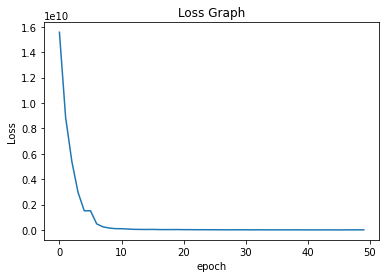

In [15]:
import matplotlib.pyplot as plt
plt.plot(lossArr)
plt.title('Loss Graph')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

In [14]:
def predict(seed, model):
    model.eval()
    res = model(seed.to(device))
    res = res.cpu().detach().numpy()
    return res

def test(dataloader, model):
    model.eval()
    size = len(dataloader.dataset)
    testLoss, correct = 0,0
    with torch.no_grad():
        for batch, (x,y) in enumerate(dataloader):
            pred = model(x)
            testLoss += loss(pred, y).item()
    testLoss /= size
    print(f"Test Error: \n Avg loss: {testLoss:>8f} \n")

test(test_loader, lstm)

Test Error: 
 Avg loss: 12.114648 



In [46]:
# # gives a 50 timestep data and generates the future 60 timesteps
# # def genPath(seed, model):
# #     model.eval()
    
# #     resAll = seed
# #     for i in range(60):
# #         resAll = np.append (resAll, predict(torch.unsqueeze(torch.FloatTensor(resAll[i:i+50]), 0), model))
# #     return resAll[51:]

# def genPath(seed, model, target_length):
#     path_w_seed = seed
#     for i in range(target_length - len(seed)):
#         path_w_seed = path_w_seed + predict(path_w_seed[i:i+len(seed)], model)
#     return path_w_seed

# genPath((all_in_1[0])[0:50], lstm, 110, )
# # predict(torch.FloatTensor(all_in_1[0][0:50]), lstm)


AttributeError: 'numpy.ndarray' object has no attribute 'to'

## Sample a batch of data and visualize 

torch.Size([4, 50, 2]) torch.Size([4, 60, 2])


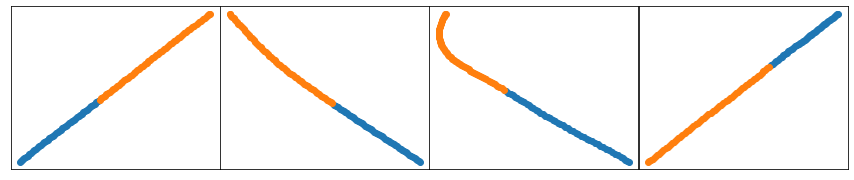

In [20]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])
        
# show_sample_batch(sample_batch)


        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    print(inp.shape, out.shape)
    show_sample_batch(sample_batch)
    break
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """